In [1]:
import pandas as pd
import numpy as np
import re
import nltk

# Import Plotting Libararies
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data Preprocessing Libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models
from sklearn import svm  

# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix

### LOAD DATASET

In [2]:
train =  pd.read_csv('C:/Users/EMAAZ/Desktop/Dataset/urdureviews/urdu_reviews_train.csv')
test =   pd.read_csv('C:/Users/EMAAZ/Desktop/Dataset/urdureviews/urdu_reviews_test.csv')
print('Shape of Training Set ' , train.shape,'\nShape of Testing Set ', test.shape)

Shape of Training Set  (40000, 2) 
Shape of Testing Set  (10000, 2)


In [3]:
data =  pd.concat([train, test]).reset_index(drop=True)
print(data.shape)

(50000, 2)


In [4]:
df =  data.copy()

In [5]:
df.head()

,review,sentiment
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive


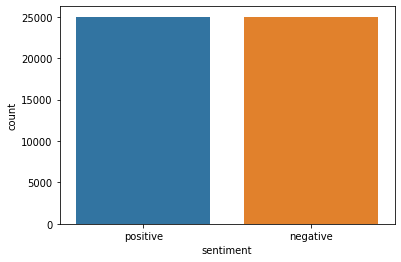

In [6]:
sns.countplot( x = 'sentiment', data = df );

### PREPROCESSING

In [7]:
le = LabelEncoder()
le.fit(df['sentiment'])
df['encoded_sentiments'] = le.transform(df['sentiment'])

In [8]:
def removing_unwanted_data(text):
    
    #format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ',text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r"[:؛؟’‘٭ء،۔]+", " ", text)
    text = re.sub(r"[٠‎١‎٢‎٣‎٤‎٥‎٦‎٧‎٨‎٩]+", " ", text)
    text = re.sub(r"[a-zA-z0-9]+", " ", text)
    
    text = nltk.WordPunctTokenizer().tokenize(text)
    
    return text



In [9]:
df['text_cleaned']= list(map(removing_unwanted_data,df.review)) #map -> name and data send in func

In [10]:
df.head()

,review,sentiment,encoded_sentiments,text_cleaned
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive,1,"[میں, نے, اسے, کی, دہائی, کے, وسط, میں, ایک, ک..."
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative,0,"[چونکہ, میں, نے, کی, دہائی, میں, انسپکٹر, گیجٹ..."
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive,1,"[ایک, ایسے, معاشرے, کی, حالت, کے, بارے, میں, ت..."
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative,0,"[مفید, البرٹ, پیون, کی, طرف, سے, ایک, اور, ردی..."
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,1,"[یہ, کولمبو, ہے, جس, کی, ہدایتکاری, اپنے, کیری..."


In [11]:
# Remove stop words from text
from typing import FrozenSet

# Urdu Language Stop words list
STOP_WORDS: FrozenSet[str] = frozenset("""
 آ آئی آئیں آئے آتا آتی آتے آس آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 ارے اس اسکا اسکی اسکے اسی اسے اف افوہ البتہ الف ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور اوپر
 اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکثر اگر اگرچہ اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر
 بج بجے بخیر بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں بھی بہت بہتر تاکہ تاہم تب تجھ
 تجھی تجھے ترا تری تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تیرا تیری تیرے
 جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے حالانکہ حالاں حصہ حضرت خاطر خالی خواہ خوب خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوں
 دکھائیں دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی
 رکھنے رکھو رکھی رکھے رہ رہا رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین
 فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو لوجی لوگوں لگ لگا لگتا
 لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محض
 مرا مرحبا مری مرے مزید مس مسز مسٹر مطابق مل مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک
 نما نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وغیرہ ولے وگرنہ وہ وہاں
 وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونی پونے پھر پہ پہلا پہلی پہلے پیر پیچھے چاہئے
 چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ چکی چکیں چکے ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاش کب کبھی
 کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کم کن کنہیں کو کوئی کون کونسا
 کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے گئی گئے گا گنا
 گو گویا گی گیا ہائیں ہائے ہاں ہر ہرچند ہرگز ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا
 ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())


def remove_stopwords(text: str):
    return " ".join(word for word in text.split() if word not in STOP_WORDS)

In [12]:
from urduhack.models.lemmatizer import lemmatizer
def lemitizeStr(str):
    lemme_str = ""
    temp = lemmatizer.lemma_lookup(str)
    for t in temp:
        lemme_str += t[0] + " "
    
    return lemme_str

In [13]:
df['review'] =  df['review'].apply(remove_stopwords)

In [14]:
df['lemmatized_text'] = df['review'].apply(lemitizeStr)

In [15]:
df.head()

,review,sentiment,encoded_sentiments,text_cleaned,lemmatized_text
0,80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...,positive,1,"[میں, نے, اسے, کی, دہائی, کے, وسط, میں, ایک, ک...",80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...
1,80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...,negative,0,"[چونکہ, میں, نے, کی, دہائی, میں, انسپکٹر, گیجٹ...",80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...
2,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,positive,1,"[ایک, ایسے, معاشرے, کی, حالت, کے, بارے, میں, ت...",معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...
3,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...,negative,0,"[مفید, البرٹ, پیون, کی, طرف, سے, ایک, اور, ردی...",مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...
4,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,positive,1,"[یہ, کولمبو, ہے, جس, کی, ہدایتکاری, اپنے, کیری...",کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...


In [16]:
print("Samples per class: {}".format(np.bincount(df.encoded_sentiments)))

Samples per class: [25000 25000]


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(df['lemmatized_text'], df['encoded_sentiments'], test_size = 0.30, random_state = 7)

In [18]:
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of Y_train', Y_train.shape)
print('Shape of Y_test', Y_test.shape)

Shape of X_train (35000,)
Shape of X_test (15000,)
Shape of Y_train (35000,)
Shape of Y_test (15000,)


### FEATURE ENGINEERING TF-IDF

In [19]:
max_feature_num = 300
vectorizer = TfidfVectorizer(max_features=max_feature_num)
train_vecs = vectorizer.fit_transform(X_train)
test_vecs = TfidfVectorizer(max_features=max_feature_num, vocabulary=vectorizer.vocabulary_).fit_transform(X_test)

### SUPPORT VECTOR MACHINE

In [20]:
def SVM_classifier(train_vecs, Y_train, test_vecs, Y_test):
    # Training
    SVM = svm.LinearSVC(max_iter=10)
    SVM.fit(train_vecs, Y_train)

    # Testing
    test_predictionSVM = SVM.predict(test_vecs)
    return classification_report(test_predictionSVM, Y_test), confusion_matrix(test_predictionSVM, Y_test)

In [21]:
class_report , conf_matrix = SVM_classifier(train_vecs, Y_train, test_vecs, Y_test)
print('Results of SVM Classifier on TF-IDF Vectorizer')
print(class_report)
print(conf_matrix)

Results of SVM Classifier on TF-IDF Vectorizer
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      5722
           1       0.88      0.72      0.79      9278

    accuracy                           0.76     15000
   macro avg       0.76      0.78      0.76     15000
weighted avg       0.79      0.76      0.77     15000

[[4829  893]
 [2641 6637]]


C:\Users\EMAAZ\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [22]:
from sklearn.svm import SVC 
# train the model on train set 
model = SVC() 
model.fit(train_vecs, Y_train) 
  
# print prediction results 
predictions = model.predict(test_vecs) 
print(classification_report(Y_test, predictions)) 
print(confusion_matrix(Y_test, predictions))

C:\Users\EMAAZ\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.81      0.77      0.79      7470
           1       0.79      0.82      0.80      7530

    accuracy                           0.80     15000
   macro avg       0.80      0.80      0.80     15000
weighted avg       0.80      0.80      0.80     15000

[[5773 1697]
 [1326 6204]]


In [23]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7983645071654479

Text(0.5, 0, 'False Positive Rate')

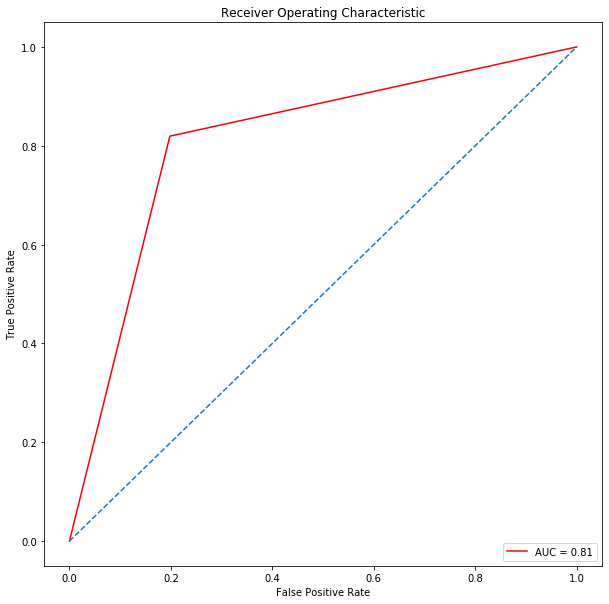

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# SVM With Tuning

In [79]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [1],  
              'gamma': [1], 
              'kernel': ['linear']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 10) 
  
# fitting the model for grid search 
grid.fit(train_vecs, Y_train) 

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] C=1, gamma=1, kernel=linear .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... C=1, gamma=1, kernel=linear, score=0.810, total= 5.6min
[CV] C=1, gamma=1, kernel=linear .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s


[CV] ......... C=1, gamma=1, kernel=linear, score=0.806, total= 5.6min
[CV] C=1, gamma=1, kernel=linear .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.2min remaining:    0.0s


[CV] ......... C=1, gamma=1, kernel=linear, score=0.812, total= 5.6min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.809, total= 5.7min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.803, total= 5.8min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.805, total= 5.8min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.817, total= 6.0min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.802, total= 5.9min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.801, total= 5.9min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 57.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1], 'gamma': [1], 'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [80]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


{'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [81]:
grid_predictions = grid.predict(test_vecs) 

# print classification report 
print(classification_report(Y_test, grid_predictions)) 
print(confusion_matrix(Y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      7470
           1       0.81      0.82      0.81      7530

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000

[[5991 1479]
 [1350 6180]]


In [82]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, grid_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.811362581801309

Text(0.5, 0, 'False Positive Rate')

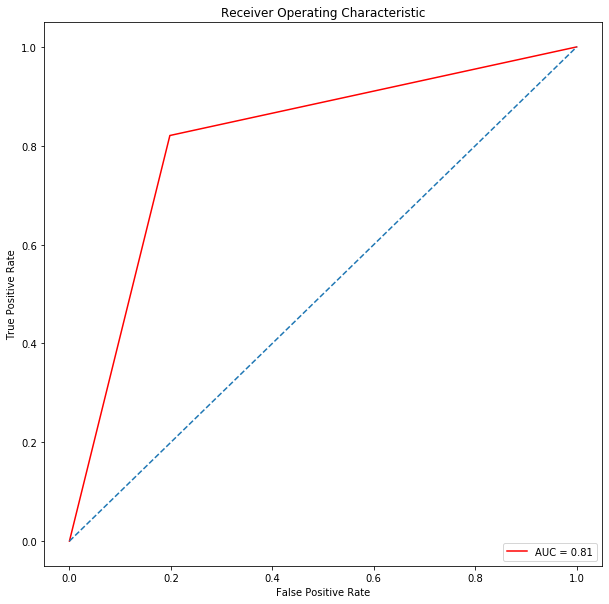

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')